## Import packages

In [1]:
!nvidia-smi

Fri Aug 13 05:22:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

     |████████████████████████████████| 435 kB 14.8 MB/s 
     |████████████████████████████████| 376 kB 65.1 MB/s 
     |████████████████████████████████| 45 kB 4.4 MB/s 


In [3]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [4]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import os
import math
import matplotlib.pyplot as plt
import numpy as np
from stellargraph import StellarGraph

import pandas as pd
import numpy as np

import stellargraph as sg
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import DeepGraphCNN
from stellargraph import StellarGraph

from stellargraph import datasets

from sklearn import model_selection
from IPython.display import display, HTML

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten,  BatchNormalization
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

In [17]:
root_path = 'https://raw.githubusercontent.com/soeai/MAppGraph/gh-pages/data'

## Config setting

In [18]:
N = 20
t = 10
k = 10  # the number of rows for the output tensor (k = 10, 20)
T = 5
overlap = 3 # note: overlap depends on T

apps = ['diijam', 'baomoi', 'fptplay', 'iQIYI', 'bigo', 'myradio', 'spotify', 'nhaccuatui', 'soundcloud', 'sachnoiapp', 
        'phim247', 'popskid', 'truyenaudiosachnoiviet', 'vieon', 'voizfm', 'tunefm', 'wetv', 'zingmp3', 'truyenaudio', 'baohay24h',
        'freefire', 'among_us', 'azar', 'comico', 'nimotv', 'mangatoon', 'medoctruyen', 'nhacvang', 'noveltoon', 'radiofm',
        'vtvgo', 'tivi24h', 'tinder', 'tinmoi24h', 'tivi360', 'tiktok', 'linkedin', 'tiki', 'tinhte', 'lotus', 'tivi247',
        'tivi_truyentranh_webtoon', 'tuoitre_online', 'vietnamworks', 'wallstreet_journal', 'cnn_news', 'bbc_news', 'twitter', 
        'weeboo', 'twitch', 'vnexpress', 'topcv', 'toc_chien', 'wesing', 'hago', 'google_meet', 'dubsmash', 'facebook','hahalolo', 
        'zalo', 'hello_yo', 'dan_tri', 'zoom', 'wikipedia', 'instagram', 'jobway', 'kaka', 'pinterest', 'quora', 'lazada', 'chess', 
        'cake', 'mobile_legend', 'co_tuong_online', 'ted', 'telegram', 'starmarker', 'skype', 'soha', 'tango', 'thanhnien', 'snapchat', 
        'tien_len', 'animal_restaurant', 'bida', 'cho_tot', 'messenger', 'netflix', 'nonolive', 'may', 'podcast_player', 'pubg', 
        'partying', 'kenh14', 'lienquan_mobile', 'likee_lite', 'reddit', 'sendo', 'shopee', 'the_guardian', 'ola_party']

features = ['complete_max', 'complete_min', 'complete_mean', 'complete_mad', 'complete_std', 'complete_var', 'complete_skew',
       'complete_kurt', 'complete_pkt_num', 'complete_10per', 'complete_20per', 'complete_30per', 'complete_40per', 'complete_50per', 
        'complete_60per', 'complete_70per', 'complete_80per', 'complete_90per', 'out_max', 'out_min', 'out_mean', 'out_mad', 'out_std',
        'out_var', 'out_skew', 'out_kurt', 'out_pkt_num', 'out_10per', 'out_20per', 'out_30per', 'out_40per', 'out_50per', 'out_60per',
        'out_70per', 'out_80per', 'out_90per', 'in_max', 'in_min', 'in_mean', 'in_mad', 'in_std', 'in_var', 'in_skew', 'in_kurt', 
        'in_pkt_num', 'in_10per', 'in_20per', 'in_30per', 'in_40per', 'in_50per', 'in_60per', 'in_70per', 'in_80per', 'in_90per', 
        'protocol', 'flows_num', 'flow_length_mean', 'flow_pkt_num_mean', 'flow_duration_mean', 'ip1', 'ip2', 'ip3', 'ip4'
       ]

In [19]:
train_graphs_folder = os.path.join(root_path, '%d_%d/train_graphs/N%d/t%d'%(T, overlap, N, t))
test_graphs_folder = os.path.join(root_path, '%d_%d/test_graphs/N%d/t%d'%(T, overlap, N, t))

## Loading graphs for training and testing

In [20]:
'''
Load graphs for one app
Input: app and folder that contains graphs of the app
Output: List of graphs (StellarGraph objects) and List of labels
'''
def graphs_one_app(app, graphs_folder):
  graphs = []

  app_graph_folder = os.path.join(graphs_folder, app)
  features_path = os.path.join(app_graph_folder, 'features.csv')
  weights_path = os.path.join(app_graph_folder, 'weights.csv')

  features_df = pd.read_csv(features_path, index_col=0)
  weights_df = pd.read_csv(weights_path, index_col=0)

  graph_num = features_df['graph_id'].iloc[-1]
  # loop over all graphs of the app
  for i in range(1, graph_num+1):
    feature_df = features_df[features_df['graph_id'] == i]
    feature_df = feature_df[['IP_port'] + features + ['graph_id']]
    feature_df = feature_df.set_index('IP_port')
    
    weight_df = weights_df[weights_df['graph_id'] == i].reset_index(drop=True)

    # drop graph_id column
    feature_df = feature_df.drop(['graph_id'], axis=1)
    weight_df = weight_df.drop(['graph_id'], axis=1)

    if weight_df.shape[0] > 0:
      graph = StellarGraph(feature_df, weight_df)
      graphs.append(graph)

    if i >= 100 and i % 100 == 0:
      print('Graph: ', i)
  
  labels = [app]*graph_num
    
  return graphs, labels

In [21]:
'''
Load all graphs
Input: folder that contains graphs
Output: List of graphs (StellarGraph objects), List of graph_labels (dummy values) and List of labels (names of app)
'''
def generate_graphs(graphs_folder):
  # build a list of graphs and labels: note that only apply for more than 2 classes
  li = []
  labels = []
  idx = 0

  for app in apps:
    idx += 1
    print('Loading {} ... {}/{}'.format(app, idx, len(apps)))
    
    one_app_graphs, one_app_labels = graphs_one_app(app, graphs_folder)
    li.extend(one_app_graphs)
    labels.extend(one_app_labels)
    

  graph_labels = pd.get_dummies(labels)
  graphs = li

  return graphs, graph_labels, labels

Load graphs from csv files



In [22]:
train_graphs, train_graph_labels, _ = generate_graphs(train_graphs_folder)
test_graphs, test_graph_labels, _ = generate_graphs(test_graphs_folder)
train_size = len(train_graphs)

graphs = train_graphs + test_graphs
graph_labels = train_graph_labels.append(test_graph_labels, ignore_index=True)

test_graph_labels = graph_labels[train_size:]

Loading diijam ... 1/101
Graph:  100
Graph:  200
Graph:  300
Loading baomoi ... 2/101
Graph:  100
Graph:  200
Graph:  300
Graph:  400
Graph:  500
Graph:  600
Loading fptplay ... 3/101
Graph:  100
Graph:  200
Graph:  300
Graph:  400
Graph:  500
Loading iQIYI ... 4/101
Graph:  100
Graph:  200
Graph:  300
Graph:  400
Graph:  500
Graph:  600
Graph:  700
Loading bigo ... 5/101
Graph:  100
Graph:  200
Graph:  300
Graph:  400
Graph:  500
Graph:  600
Graph:  700
Graph:  800
Graph:  900
Loading myradio ... 6/101
Graph:  100
Graph:  200
Graph:  300
Graph:  400
Loading spotify ... 7/101
Graph:  100
Graph:  200
Graph:  300
Graph:  400
Graph:  500
Graph:  600
Graph:  700
Graph:  800
Loading nhaccuatui ... 8/101
Graph:  100
Graph:  200
Graph:  300
Graph:  400
Graph:  500
Graph:  600
Graph:  700
Graph:  800
Graph:  900
Graph:  1000
Graph:  1100
Graph:  1200
Loading soundcloud ... 9/101
Graph:  100
Graph:  200
Graph:  300
Graph:  400
Graph:  500
Graph:  600
Graph:  700
Graph:  800
Loading sachnoiapp .

In [23]:
generator = PaddedGraphGenerator(graphs=graphs)

## Build GNN

In [30]:
layer_sizes = [1024, 1024, 1024, 512]

dgcnn_model = DeepGraphCNN(
    layer_sizes=layer_sizes,
    activations=["tanh", "tanh", "tanh", "tanh"],
    k=k,
    bias=False,
    generator=generator,
)
x_inp, x_out = dgcnn_model.in_out_tensors()

#------------------------------------------------------------------------------
x_out = Conv1D(filters=256, kernel_size=sum(layer_sizes), strides=sum(layer_sizes))(x_out)
x_out = MaxPool1D(pool_size=2)(x_out)

x_out = Conv1D(filters=512, kernel_size=5, strides=1)(x_out)

x_out = Flatten()(x_out)

x_out = Dense(units=1024, activation="relu")(x_out)
x_out = Dropout(rate=0.25)(x_out)

predictions = Dense(units=len(apps), activation="softmax")(x_out)

#------------------------------------------------------------------------------

model = Model(inputs=x_inp, outputs=predictions)

# using exponentialDecay to decrease the learning rate after 10 epochs
# lr =  initial_lr * decay_rate ^ (step / decay_steps)
batch_size = 256
decay_epoch = 10

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=(train_size//batch_size)*decay_epoch,
    decay_rate=0.9)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer, loss=categorical_crossentropy, metrics=["acc"],
)

In [31]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, 63)]   0                                            
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, None, 63)     0           input_4[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, None, None)] 0                                            
__________________________________________________________________________________________________
graph_convolution_4 (GraphConvo (None, None, 1024)   64512       dropout_5[0][0]                  
                                                                 input_6[0][0]              

In [32]:
gen = PaddedGraphGenerator(graphs=graphs)

train_gen = gen.flow(
    list(train_graph_labels.index - 1),
    targets=train_graph_labels.values,
    batch_size=256,
    symmetric_normalization=False,
)

test_gen = gen.flow(
    list(test_graph_labels.index - 1),
    targets=test_graph_labels.values,
    batch_size=256,
    symmetric_normalization=False,
)

## Training

In [33]:
class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 10 == 0 & epoch > 0:  # or save after some epoch, each k-th epoch etc.
            self.model.save(os.path.join(models_folder, "model_{}.hd5".format(epoch)))
# create and use callback:
saver = CustomSaver()

epochs = 150
history = model.fit(
    train_gen, callbacks=[saver], epochs=epochs, verbose=1, validation_data=test_gen, shuffle=True,
)

Epoch 1/150
259/259 [==============================] - 104s 396ms/step - loss: 4.4978 - acc: 0.0398 - val_loss: 3.7768 - val_acc: 0.1291
Epoch 2/150
259/259 [==============================] - 102s 393ms/step - loss: 3.6325 - acc: 0.1439 - val_loss: 2.9681 - val_acc: 0.2506
Epoch 3/150
259/259 [==============================] - 100s 386ms/step - loss: 3.0363 - acc: 0.2285 - val_loss: 2.4834 - val_acc: 0.3764
Epoch 4/150
259/259 [==============================] - 101s 391ms/step - loss: 2.5972 - acc: 0.3230 - val_loss: 2.1442 - val_acc: 0.4455
Epoch 5/150
259/259 [==============================] - 101s 389ms/step - loss: 2.3028 - acc: 0.3948 - val_loss: 1.9628 - val_acc: 0.4994
Epoch 6/150
259/259 [==============================] - 100s 386ms/step - loss: 2.0830 - acc: 0.4489 - val_loss: 1.7769 - val_acc: 0.5344
Epoch 7/150
259/259 [==============================] - 101s 390ms/step - loss: 1.9148 - acc: 0.4873 - val_loss: 1.5742 - val_acc: 0.5930
Epoch 8/150
259/259 [====================

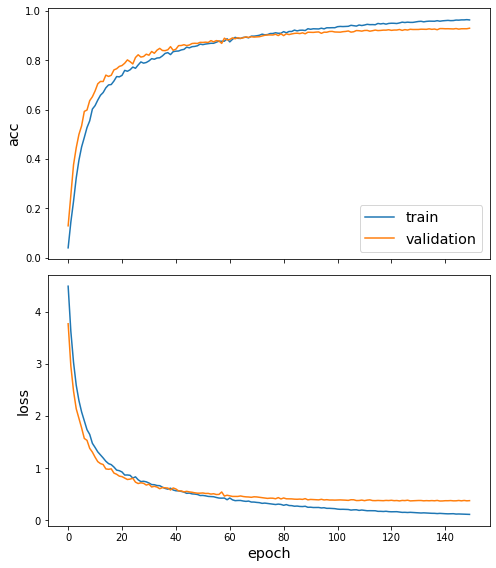

In [34]:
sg.utils.plot_history(history)

## Testing

In [35]:
# use the model to predict on testing data and get predicted labels
pred_prob = model.predict(test_gen)
pred_labels = np.argmax(pred_prob, axis=-1) 
pred_labels = [str(x+1) for x in list(pred_labels)]

# get the true labels of the testing data
test_labels = np.argmax(test_graph_labels.values, axis=-1)
test_labels = [str(x+1) for x in list(test_labels)]

# show the result as classification report
print(classification_report(test_labels, pred_labels, target_names=apps, digits=4))

                          precision    recall  f1-score   support

                  diijam     0.9444    0.9623    0.9533       159
                  baomoi     0.8901    0.9257    0.9076       175
                 fptplay     0.9685    0.9498    0.9591       259
                   iQIYI     0.9693    0.9405    0.9547       168
                    bigo     0.9556    0.9399    0.9477       183
                 myradio     0.9562    0.9291    0.9424       141
                 spotify     0.9014    0.9275    0.9143       138
              nhaccuatui     0.8984    0.9231    0.9106       182
              soundcloud     0.9302    0.8649    0.8964       185
              sachnoiapp     0.9429    0.9340    0.9384       106
                 phim247     0.9400    0.9038    0.9216       156
                 popskid     0.9223    0.9418    0.9319       189
  truyenaudiosachnoiviet     0.9412    0.9739    0.9573       115
                   vieon     0.8069    0.8864    0.8448       132
         

-------------------------------------------------------------